In [ ]:
import os
import time
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import torch.nn.functional as F
from PIL import Image
import cv2
import random
from sklearn.model_selection import train_test_split
import torch.nn.utils.prune as prune
import json
import zipfile
from google.colab import drive

drive.mount('/content/drive')

with zipfile.ZipFile("/content/drive/MyDrive/Yeni WinRAR ZIP arşivi2.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

Mounted at /content/drive


resnet 18

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/100]  Train Loss: 1.8205  Val Loss: 0.5954  Time: 24.22s
Epoch [2/100]  Train Loss: 0.5248  Val Loss: 0.3348  Time: 22.50s
Epoch [3/100]  Train Loss: 0.3418  Val Loss: 0.2334  Time: 22.59s
Epoch [4/100]  Train Loss: 0.2555  Val Loss: 0.1747  Time: 22.70s
Epoch [5/100]  Train Loss: 0.2038  Val Loss: 0.1697  Time: 22.99s
Epoch [6/100]  Train Loss: 0.1700  Val Loss: 0.1194  Time: 23.13s
Epoch [7/100]  Train Loss: 0.1391  Val Loss: 0.1147  Time: 23.07s
Epoch [8/100]  Train Loss: 0.1196  Val Loss: 0.0912  Time: 22.91s
Epoch [9/100]  Train Loss: 0.1096  Val Loss: 0.1306  Time: 22.94s
Epoch

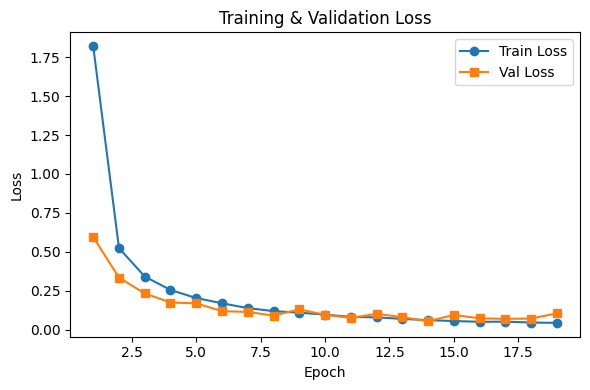


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9891,0.9526,0.9705,190.0
Tomato___Early_blight,1.0000,0.7143,0.8333,98.0
Tomato___Late_blight,0.8697,1.0000,0.9303,207.0
Tomato___Leaf_Mold,0.9903,0.9533,0.9714,107.0
Tomato___Septoria_leaf_spot,0.9773,0.9885,0.9829,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9425,0.9480,0.9452,173.0
Tomato___Target_Spot,0.9139,0.9583,0.9356,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9943,0.9943,0.9943,524.0
Tomato___Tomato_mosaic_virus,1.0000,0.9579,0.9785,95.0
Tomato___healthy,0.9806,0.9935,0.9870,153.0



✅ Genel Accuracy: 0.9641


<ipython-input-2-8ce6ff52e068>:181: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


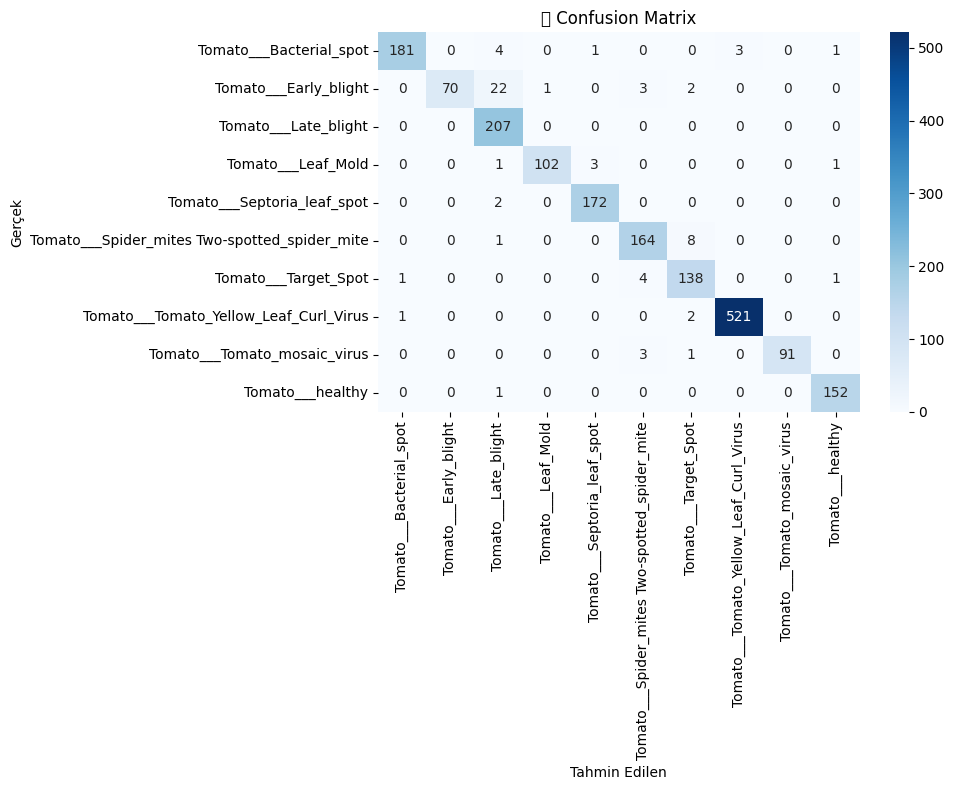

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model1 = timm.create_model('resnet18', pretrained=False)
in_features = model1.num_features if hasattr(model1, 'num_features') else model1.head.in_features
model1.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 100
train_losses = []
val_losses   = []

# EarlyStop fonksiyonu
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(1, epochs+1):
    # -- Train --
    model1.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model1.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}"
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping kontrolü
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"⏹️ Early stopping at epoch {epoch}")
        break

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
plt.figure(figsize=(6,4))
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model1.state_dict(), "resnet18.pth")

# --- 6) Son test & rapor ---
model1.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

şimdi resnet 34

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/100]  Train Loss: 1.6827  Val Loss: 0.5453  Time: 36.13s
Epoch [2/100]  Train Loss: 0.4300  Val Loss: 0.3571  Time: 36.19s
Epoch [3/100]  Train Loss: 0.2967  Val Loss: 0.2490  Time: 36.00s
Epoch [4/100]  Train Loss: 0.2298  Val Loss: 0.1976  Time: 36.14s
Epoch [5/100]  Train Loss: 0.1912  Val Loss: 0.1840  Time: 36.16s
Epoch [6/100]  Train Loss: 0.1599  Val Loss: 0.1013  Time: 36.13s
Epoch [7/100]  Train Loss: 0.1361  Val Loss: 0.1522  Time: 36.16s
Epoch [8/100]  Train Loss: 0.1208  Val Loss: 0.1076  Time: 36.25s
Epoch [9/100]  Train Loss: 0.1095  Val Loss: 0.1275  Time: 36.28s
Epoch

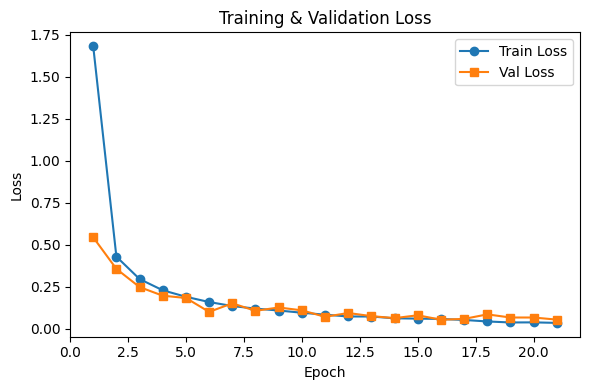


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9594,0.9947,0.9767,190.0
Tomato___Early_blight,0.9412,0.9796,0.9600,98.0
Tomato___Late_blight,0.9902,0.9758,0.9830,207.0
Tomato___Leaf_Mold,1.0000,1.0000,1.0000,107.0
Tomato___Septoria_leaf_spot,1.0000,0.9713,0.9854,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9702,0.9422,0.9560,173.0
Tomato___Target_Spot,0.9514,0.9514,0.9514,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9886,0.9943,0.9914,524.0
Tomato___Tomato_mosaic_virus,1.0000,0.9895,0.9947,95.0
Tomato___healthy,1.0000,1.0000,1.0000,153.0



✅ Genel Accuracy: 0.9818


<ipython-input-3-9a72f20bee0d>:181: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


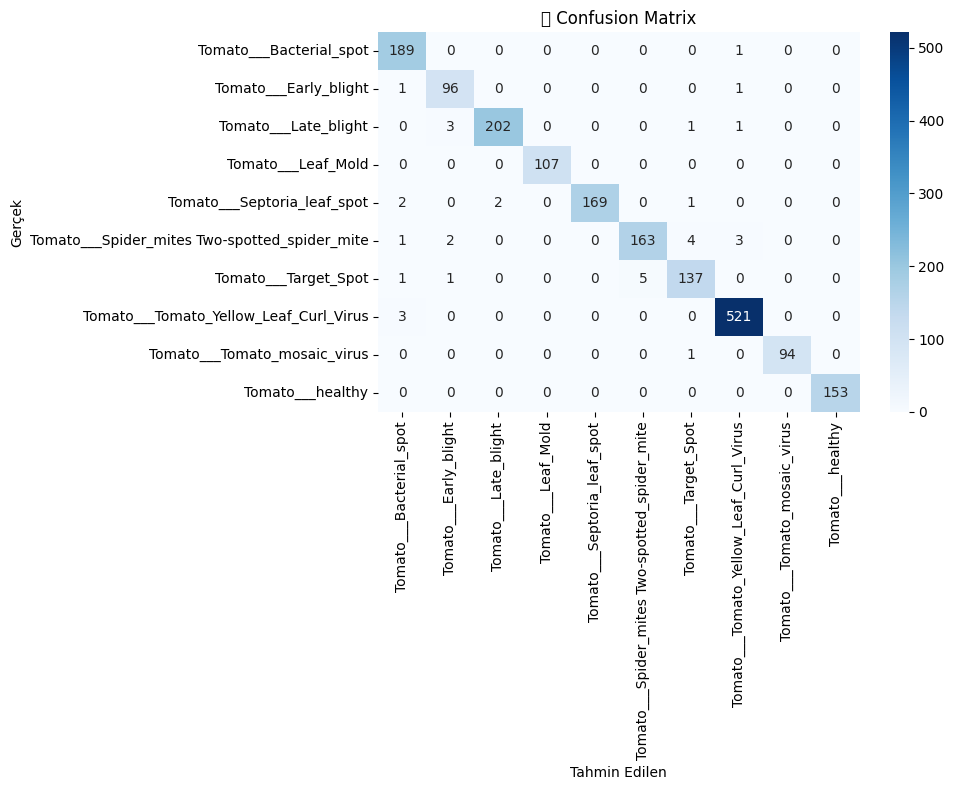

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model2 = timm.create_model('resnet34', pretrained=False)
in_features = model2.num_features if hasattr(model2, 'num_features') else model2.head.in_features
model2.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 100
train_losses = []
val_losses   = []

# EarlyStop fonksiyonu
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(1, epochs+1):
    # -- Train --
    model2.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}"
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping kontrolü
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"⏹️ Early stopping at epoch {epoch}")
        break

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
plt.figure(figsize=(6,4))
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model2.state_dict(), "resnet34.pth")

# --- 6) Son test & rapor ---
model2.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

şimdi de resnet50

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/100]  Train Loss: 0.9199  Val Loss: 0.4989  Time: 74.08s
Epoch [2/100]  Train Loss: 0.3641  Val Loss: 0.2924  Time: 73.89s
Epoch [3/100]  Train Loss: 0.2635  Val Loss: 0.2451  Time: 73.85s
Epoch [4/100]  Train Loss: 0.2060  Val Loss: 0.1744  Time: 73.88s
Epoch [5/100]  Train Loss: 0.1672  Val Loss: 0.1437  Time: 73.92s
Epoch [6/100]  Train Loss: 0.1433  Val Loss: 0.1457  Time: 73.89s
Epoch [7/100]  Train Loss: 0.1157  Val Loss: 0.1273  Time: 73.87s
Epoch [8/100]  Train Loss: 0.0976  Val Loss: 0.0770  Time: 73.87s
Epoch [9/100]  Train Loss: 0.0961  Val Loss: 0.0911  Time: 73.87s
Epoch

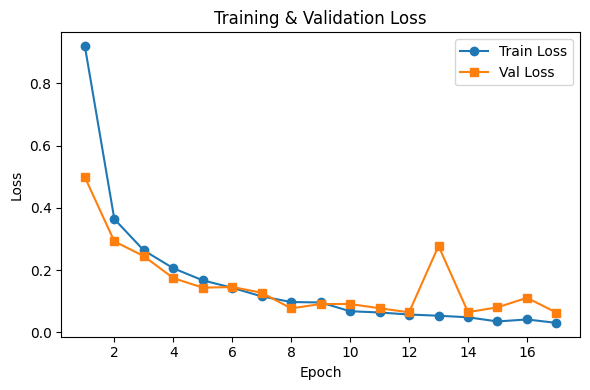


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9585,0.9737,0.9661,190.0
Tomato___Early_blight,0.9684,0.9388,0.9534,98.0
Tomato___Late_blight,0.9452,1.0000,0.9718,207.0
Tomato___Leaf_Mold,1.0000,0.9720,0.9858,107.0
Tomato___Septoria_leaf_spot,0.9942,0.9828,0.9884,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9708,0.9595,0.9651,173.0
Tomato___Target_Spot,0.9648,0.9514,0.9580,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9942,0.9885,0.9914,524.0
Tomato___Tomato_mosaic_virus,0.9895,0.9895,0.9895,95.0
Tomato___healthy,0.9935,0.9935,0.9935,153.0



✅ Genel Accuracy: 0.9791


<ipython-input-4-f3b1da7a704d>:181: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


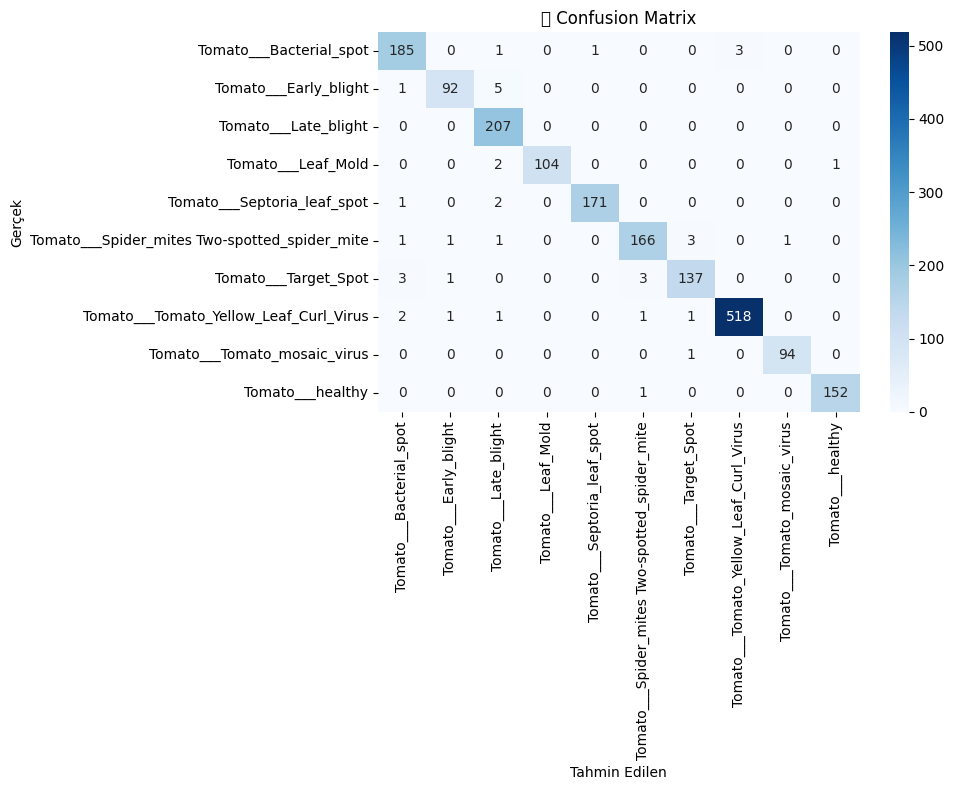

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model3 = timm.create_model('resnet50', pretrained=False)
in_features = model3.num_features if hasattr(model3, 'num_features') else model3.head.in_features
model3.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 100
train_losses = []
val_losses   = []

# EarlyStop fonksiyonu
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(1, epochs+1):
    # -- Train --
    model3.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model3.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}"
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping kontrolü
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"⏹️ Early stopping at epoch {epoch}")
        break

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
plt.figure(figsize=(6,4))
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model3.state_dict(), "resnet50.pth")

# --- 6) Son test & rapor ---
model3.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model3(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

📊 Evaluating ResNet18...
📊 Evaluating ResNet34...
📊 Evaluating ResNet50...

📈 Karşılaştırmalı Sınıflandırma Performansı:


,Model,Precision,Recall,F1-Score,Accuracy
0,ResNet18,0.9666,0.9641,0.9634,0.9641
1,ResNet34,0.9820,0.9818,0.9818,0.9818
2,ResNet50,0.9794,0.9791,0.9791,0.9791


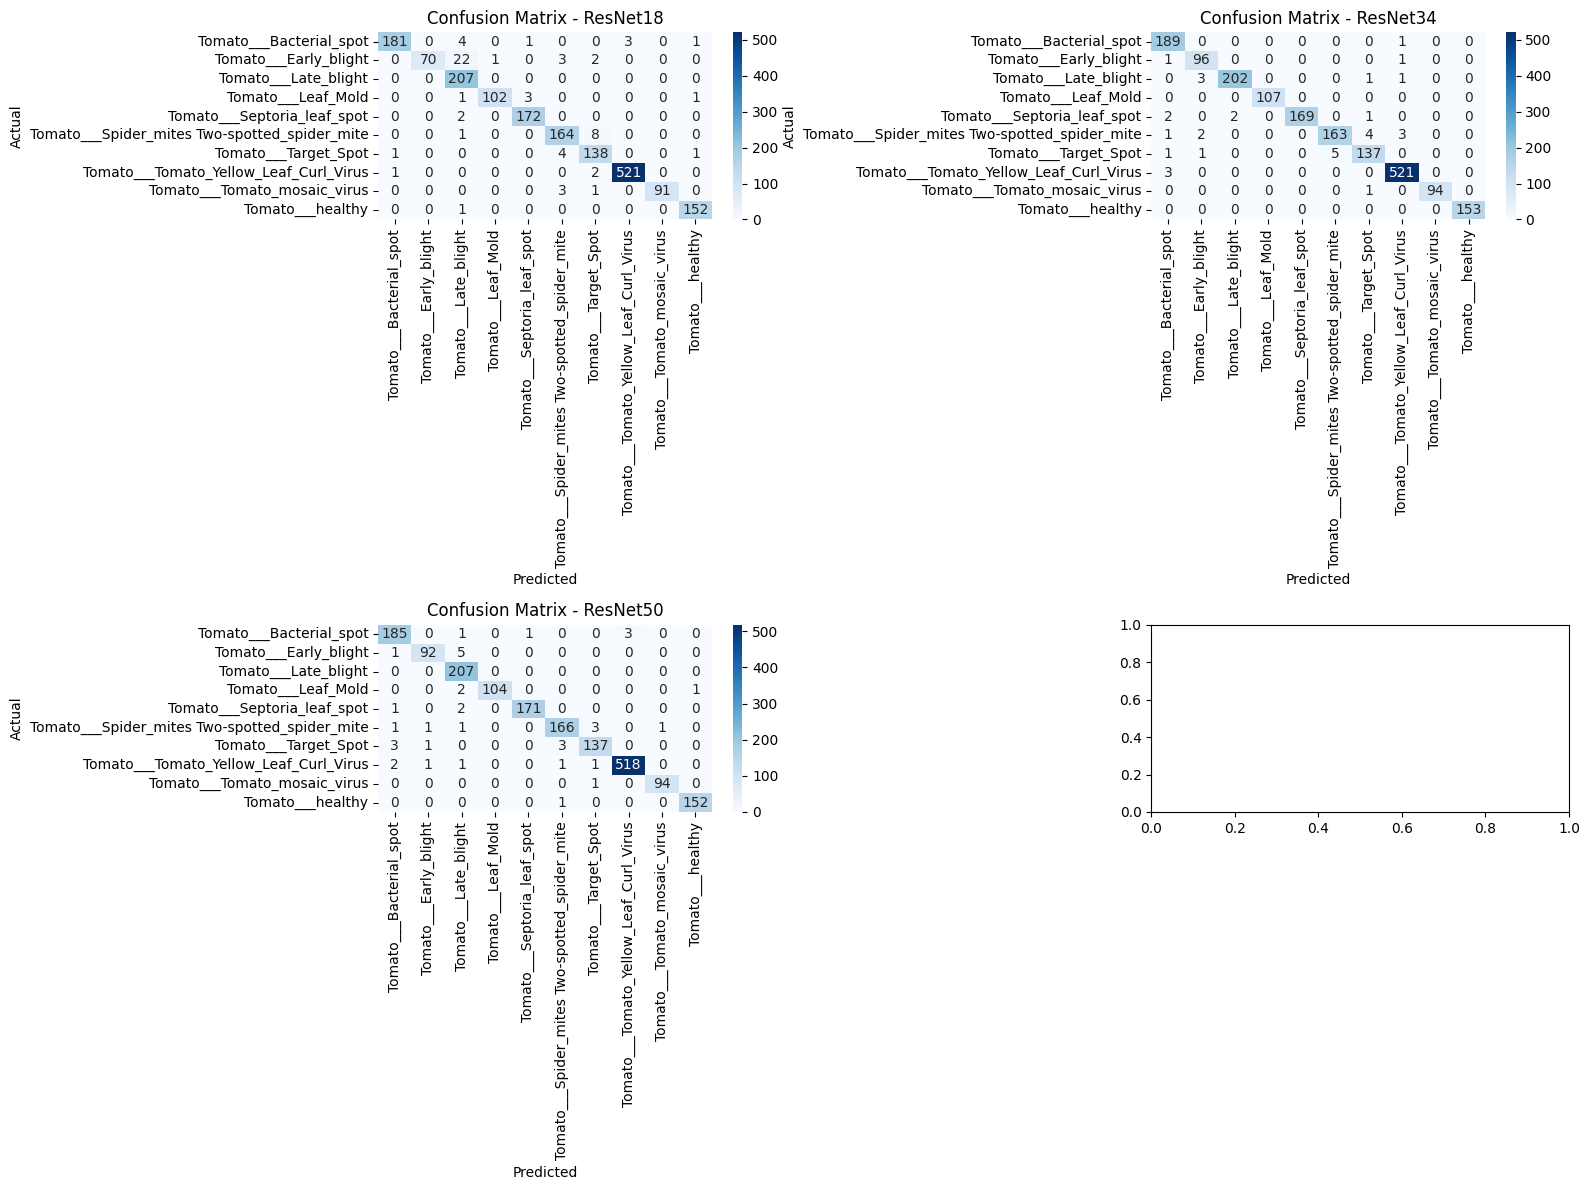

In [ ]:
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        output_dict=True
    )

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    return report, cm

    # Değerlendirmeyi yapacağımız modeller
models = {
    "ResNet18": model1,
    "ResNet34": model2,
    "ResNet50": model3
}

reports = {}
conf_matrices = {}

for name, model in models.items():
    print(f"📊 Evaluating {name}...")
    report, cm = evaluate_model(model, test_loader, class_names, device)
    reports[name] = report
    conf_matrices[name] = cm

    # Her model için weighted avg (veya macro avg) precision, recall, f1-score değerlerini toplayalım
summary_data = []

for name, report in reports.items():
    row = {
        "Model": name,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "Accuracy": report["accuracy"]
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print("\n📈 Karşılaştırmalı Sınıflandırma Performansı:")
display(summary_df)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_matrices.items()):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

burada da semantic dictionary metodunu test ediyorum, 10 farklı sınıfın her biri için anlamlı channel'ları tespit ediyorum.

In [ ]:
models_path_list = ["/content/resnet18.pth", "/content/resnet34.pth", "/content/resnet50.pth"]
models_name_list = ["resnet18", "resnet34", "resnet50"]
important_channels_combined = []

for models_name in models_name_list:
  for models_path in models_path_list:
    if models_name in models_path:

      #semantic veriyi liste olarak kaydettiğim, yani 50 channelın tamamını classına bakmaksızın kaydediyoruz
      # Modeli doğru sınıf sayısıyla başlat
      model = timm.create_model(models_name, pretrained=False, num_classes=10)

      # Ağırlıkları yüklemeden önce state_dict'i oku
      state_dict = torch.load(models_path, map_location=torch.device("cpu"))

      # ❌ FC katmanı ağırlıklarını çıkar
      state_dict = {k: v for k, v in state_dict.items() if not k.startswith("fc.")}

      # Geri kalan ağırlıkları yükle (strict=False gerekmez artık)
      model.load_state_dict(state_dict, strict=False)
      model.eval()

      # 🧠 GAP öncesi son conv katmanını bul
      if models_name == "resnet18" or models_name == "resnet34":
        target_layer = model.layer4[-1].conv2
      else:
        target_layer = model.layer4[-1].conv3
      feature_maps = []

      def forward_hook(module, input, output):
          feature_maps.append(output.detach())

      hook_handle = target_layer.register_forward_hook(forward_hook)

      # 📂 Validation verisini yükle
      data_dir = "/content/without_augmentation"
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
      dataset = datasets.ImageFolder(data_dir, transform=transform)
      dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
      class_names = dataset.classes

      # 🔍 Her örnek için gerçek etiketli feature map katkısını al
      semantic_dict = {}              # {class_idx: [channel_contributions]}
      important_channels_set = set() # ❗ Tüm sınıfların önemli kanallarını saklayan set

      for img_tensor, label in dataloader:
          feature_maps.clear()
          output = model(img_tensor)

          true_class = label.item()  # gerçek sınıf etiketi
          weights = model.fc.weight[true_class]  # sınıfa özel FC ağırlıkları

          fmap = feature_maps[0]            # (1, C, H, W)
          fmap = fmap.squeeze(0)            # (C, H, W)
          pooled = torch.mean(fmap.view(fmap.shape[0], -1), dim=1)  # GAP: (C,)

          contribution = pooled * weights   # kanal katkı değeri (C,)

          if true_class not in semantic_dict:
              semantic_dict[true_class] = []

          semantic_dict[true_class].append(contribution.detach().cpu().numpy())

      # 📊 Her sınıf için ortalama katkı vektörünü yazdır + önemli kanalları topla
      for cls, contribs in semantic_dict.items():
          contribs = np.stack(contribs)
          mean_contrib = np.mean(contribs, axis=0)
          top_channels = np.argsort(-mean_contrib)[:5]  # en büyük 5 kanal

          #print(f"\n🔸 Sınıf: {class_names[cls]} (Index {cls}) için en anlamlı 5 kanal:")
          for idx in top_channels:
          #    print(f"   Kanal {idx}: katkı = {mean_contrib[idx]:.4f}")
              important_channels_set.add(idx)  # ✅ Tekrarsız olarak ekle

      # ✅ Tüm önemli kanalları topla ve sırala
      important_channels = sorted(list(important_channels_set))
      print(f"\n📦 Tüm sınıflarda öne çıkan toplam {len(important_channels)} kanal:")
      print(important_channels)
      important_channels_combined.append(important_channels)

for i in important_channels_combined:
  print(i)


📦 Tüm sınıflarda öne çıkan toplam 40 kanal:
[np.int64(20), np.int64(22), np.int64(56), np.int64(64), np.int64(65), np.int64(78), np.int64(89), np.int64(96), np.int64(97), np.int64(104), np.int64(147), np.int64(216), np.int64(265), np.int64(267), np.int64(270), np.int64(274), np.int64(285), np.int64(294), np.int64(295), np.int64(311), np.int64(323), np.int64(341), np.int64(370), np.int64(376), np.int64(392), np.int64(403), np.int64(406), np.int64(410), np.int64(420), np.int64(425), np.int64(441), np.int64(450), np.int64(456), np.int64(461), np.int64(487), np.int64(496), np.int64(497), np.int64(499), np.int64(507), np.int64(510)]

📦 Tüm sınıflarda öne çıkan toplam 43 kanal:
[np.int64(22), np.int64(35), np.int64(42), np.int64(44), np.int64(45), np.int64(46), np.int64(62), np.int64(66), np.int64(80), np.int64(82), np.int64(84), np.int64(85), np.int64(87), np.int64(88), np.int64(97), np.int64(148), np.int64(159), np.int64(190), np.int64(197), np.int64(210), np.int64(226), np.int64(229), np